In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [2]:
budget = 10000
contract = 300
income = 50
exposure = 0.18
contract_limit = 10
days_limit = 60

In [3]:
G = nx.read_edgelist('edge_list.txt')

In [4]:
cc = nx.connected_components(G)
cc = list(cc)

In [5]:
cc_lengths = pd.Series([len(c) for c in cc], name='cc_lengths')
cc_lengths

0     3732
1        2
2        3
3        2
4        2
5        2
6      180
7        9
8        6
9        3
10       2
11       2
12       2
13       4
14       2
Name: cc_lengths, dtype: int64

In [284]:
def get_good_neighbors(node, threshold):
    #threshold = G.degree[str(node)] // 2
    neighbors = list(G.neighbors(str(node)))
    degrees = list(G.degree[x] for x in neighbors)
    neighbors_degrees = np.stack([list(map(int, neighbors)), degrees],axis=1)
    #display(neighbors_degrees)
    neighbors_good = neighbors_degrees[neighbors_degrees[:,1] <= threshold,:]
    return list(neighbors_good) if len(neighbors_good) else np.nan
    
display(G.degree['2949'])
get_good_neighbors(2949, 5)


19

[array([3310,    4])]

In [285]:
cliques_num = 0
cliques = {}
clique_component = {}
clique_lengths = {}

#def analyze_subgraph(c):
c = 0
if True:
    subG = G.subgraph(cc[c])
        
    nodes = []
    node_clique = []
    node_clique_nodes = []
    node_clique_length = []
    node_degrees = []
    node_neighbors = []
    node_neighbors_count = []
    node_neighbors_degrees = []
    node_neighbors_good = []
    
#    cliques = nx.algorithms.community.k_clique_communities(subG, 4)

    cliques = []
    with open('5_0_clique_good.txt', 'r') as f:
        cliques = list(map(eval, f.readlines()))
        
    for clique in cliques:
        cliques[cliques_num] = clique
        clique_component[cliques_num] = c
        clique_lengths[cliques_num] = len(clique)
        
        for node in clique: #tqdm(clique):
            v = int(node)
            nodes.append(node)
            node_degrees.append(G.degree[node])
            node_clique.append(cliques_num)
            
            node_clique_nodes.append(list(clique))
            node_neighbors.append(list(G.neighbors(node)))
            node_neighbors_degrees.append(list((x, G.degree[x]) for x in node_neighbors[-1]))
            node_neighbors_good.append(get_good_neighbors(node, 5))
            
        cliques_num += 1

    df = pd.concat([
        pd.Series(nodes, name='node'),
        pd.Series(node_degrees, name='degree'),
        pd.Series(node_clique, name='clique')
    ], axis=1)

    df['clique_nodes'] = pd.Series(node_clique_nodes)
    df['clique_length'] = df['clique_nodes'].apply(len)
    df['neighbors'] = pd.Series(node_neighbors)
    df['neighbors_degrees'] = pd.Series(node_neighbors_degrees)
    df['neighbors_good'] = pd.Series(node_neighbors_good).replace(list(), np.nan)
    
    # return df

In [435]:
class Model:
    def __init__(self, budget=10000, cost=300, income=50, threshold=0.18, max_contracts=10, max_days=60):
        self.G = nx.read_edgelist('edge_list.txt')
        self.cc = list(nx.connected_components(G))
        self.budget = budget
        self.cost = cost
        self.income = 50
        self.threshold = threshold
        self.max_contracts=10
        self.max_days=60
        self.profit = 0
        self.timeline = 0
        self.contracts = set()
        self.affected = set()
        
    def draw(self, figsize=(16, 16)):
        nodes = self.contracts | self.affected
        neighbors = self.expand_neighbors(nodes)
        neighbors = self.expand_neighbors(neighbors)
        nodes |= neighbors
        
        subG = G.subgraph(nodes)
        pos = nx.kamada_kawai_layout(subG)

        plt.figure(figsize=figsize)
        nx.draw_networkx_nodes(neighbors, pos, node_color='gray')
        nx.draw_networkx_nodes(self.contracts, pos, node_color='green')
        nx.draw_networkx_nodes(self.affected, pos, node_color='yellow')
        nx.draw_networkx_edges(subG, pos)
        nx.draw_networkx_labels(subG, pos)
        plt.show()
        
    def draw_neighbors(self, node, force=False, figsize=(16, 16)):
        degree = G.degree[str(node)]
        display(degree)
        if not force and degree > 10:
            return
        nodes = set([str(node)]) | set(G.neighbors(str(node)))
        neighbors = self.expand_neighbors(nodes) - nodes
        subG = G.subgraph(nodes | neighbors | self.affected)
        pos = nx.kamada_kawai_layout(subG)
        plt.figure(figsize=figsize)
        nx.draw_networkx_nodes(neighbors, pos, node_color='gray')
        #nx.draw_networkx_nodes(self.affected, pos, node_color='yellow')
        nx.draw_networkx_nodes(nodes - self.affected, pos, node_color='blue')
        nx.draw_networkx_nodes([str(node)], pos, node_color='green')
        nx.draw_networkx_edges(subG, pos)
        nx.draw_networkx_labels(subG, pos)
        plt.show()
        
    def expand_neighbors(self, nodes):
        neighbors = set()
        for n in nodes:
            neighbors |= set(G.neighbors(n))
        return neighbors
    
    def update_affected(self):
        neighbors = expand_neighbors(self.affected)
        new_affected = set()
        for node in neighbors:
            if node not in self.affected:
                node_neighbors = set(G.neighbors(node))
                node_affected = node_neighbors & self.affected
                if len(node_affected) / len(node_neighbors) >= self.threshold:
                    new_affected.add(node)
        income = self.income * len(new_affected)
        self.profit += income
        display(f"Affected: {new_affected}, Income: {income}, Profit: {self.profit}")
        self.affected |= new_affected
        return self

    def add_contract(self, nodes):
        new_contracts = set(map(str, nodes))
        self.contracts |= new_contracts
        self.affected |= new_contracts
        cost = sum(self.cost * G.degree[v] for v in new_contracts)
        self.profit -= cost
        if self.profit < -10000:
            raise ValueError('profit')
        display(f"Signed contracts: {new_contracts}, Cost: {cost}, Profit: {self.profit}")
        return self
    
    def next_day(self):
        self.update_affected()
        display(f"Day: {self.timeline}, Total: {self.budget + self.profit}, "
                f"Profit: {self.profit}, Affected: {len(self.affected)}")
        self.timeline += 1
        return self
    
    def next_days(self, count):
        for _ in range(count):
            self.next_day()
        return self


In [429]:
good = True#(df['neighbors_good'].apply(lambda x: sum(v[1] for v in x)) < df['degree'])
mask = (df['clique_length']>=7) & (df['clique']!=25) & good
df[mask].dropna().sort_values(by=['clique_length', 'degree']).head(30)
#df[df['clique']==25].sort_values(by=['clique_length', 'degree'])

,node,degree,clique,clique_nodes,clique_length,neighbors,neighbors_degrees,neighbors_good
27,167,6,3,"[243, 93, 111, 310, 137, 167, 337]",7,"[137, 310, 32, 243, 93, 337]","[(137, 15), (310, 12), (32, 5), (243, 7), (93,...","[[32, 5]]"
22,243,7,3,"[243, 93, 111, 310, 137, 167, 337]",7,"[312, 137, 310, 41, 216, 167, 337]","[(312, 25), (137, 15), (310, 12), (41, 23), (2...","[[216, 1]]"
23,93,7,3,"[243, 93, 111, 310, 137, 167, 337]",7,"[137, 111, 310, 32, 167, 337, 41]","[(137, 15), (111, 13), (310, 12), (32, 5), (16...","[[32, 5]]"
220,501,7,23,"[501, 393, 198, 441, 364, 564, 399]",7,"[198, 364, 441, 476, 399, 564, 393]","[(198, 10), (364, 8), (441, 7), (476, 5), (399...","[[476, 5]]"
223,441,7,23,"[501, 393, 198, 441, 364, 564, 399]",7,"[198, 364, 476, 501, 399, 564, 393]","[(198, 10), (364, 8), (476, 5), (501, 7), (399...","[[476, 5]]"
226,399,7,23,"[501, 393, 198, 441, 364, 564, 399]",7,"[198, 364, 441, 476, 501, 393, 564]","[(198, 10), (364, 8), (441, 7), (476, 5), (501...","[[476, 5]]"
352,3932,7,38,"[3932, 3799, 3616, 3716, 3439, 3647, 3638]",7,"[3799, 3638, 3616, 3513, 3716, 3647, 3439]","[(3799, 13), (3638, 10), (3616, 11), (3513, 5)...","[[3513, 5]]"
28,337,8,3,"[243, 93, 111, 310, 137, 167, 337]",7,"[137, 111, 310, 32, 243, 167, 93, 41]","[(137, 15), (111, 13), (310, 12), (32, 5), (24...","[[32, 5]]"
224,364,8,23,"[501, 393, 198, 441, 364, 564, 399]",7,"[198, 441, 501, 476, 399, 393, 351, 564]","[(198, 10), (441, 7), (501, 7), (476, 5), (399...","[[476, 5], [351, 4]]"
225,564,8,23,"[501, 393, 198, 441, 364, 564, 399]",7,"[198, 364, 441, 399, 501, 351, 393, 454]","[(198, 10), (364, 8), (441, 7), (399, 7), (501...","[[351, 4], [454, 2]]"


'Affected: set(), Income: 0, Profit: 0'

'Day: 0, Total: 10000, Profit: 0, Affected: 0'

"Signed contracts: {'3652', '3606', '3922', '3600', '3961', '3548'}, Cost: 9000, Profit: -9000"

"Affected: {'3925', '3897', '3536', '3676', '3727', '3745', '3489', '3665', '3661'}, Income: 450, Profit: -8550"

'Day: 1, Total: 1450, Profit: -8550, Affected: 15'

"Affected: {'3487', '3949', '3908', '3551', '3812', '3441', '3662', '3825'}, Income: 400, Profit: -8150"

'Day: 2, Total: 1850, Profit: -8150, Affected: 23'

"Affected: {'3893', '3624', '3549', '3811', '3814', '3546', '3723', '3682', '3530', '3614', '3531', '3566', '3583', '3771', '3504'}, Income: 750, Profit: -7400"

'Day: 3, Total: 2600, Profit: -7400, Affected: 38'

"Affected: {'3447', '3963', '3459', '3905', '3679', '3490', '3839', '3939', '3863', '3446', '3585', '3806', '3494', '3673'}, Income: 700, Profit: -6700"

'Day: 4, Total: 3300, Profit: -6700, Affected: 52'

"Affected: {'3626', '3612', '3580', '3894'}, Income: 200, Profit: -6500"

'Day: 5, Total: 3500, Profit: -6500, Affected: 56'

"Affected: {'3941', '3534'}, Income: 100, Profit: -6400"

'Day: 6, Total: 3600, Profit: -6400, Affected: 58'

"Affected: {'3564', '3770'}, Income: 100, Profit: -6300"

'Day: 7, Total: 3700, Profit: -6300, Affected: 60'

"Affected: {'3678'}, Income: 50, Profit: -6250"

'Day: 8, Total: 3750, Profit: -6250, Affected: 61'

"Affected: {'3539'}, Income: 50, Profit: -6200"

'Day: 9, Total: 3800, Profit: -6200, Affected: 62'

"Affected: {'3890', '3724'}, Income: 100, Profit: -6100"

'Day: 10, Total: 3900, Profit: -6100, Affected: 64'

"Affected: {'3511'}, Income: 50, Profit: -6050"

'Day: 11, Total: 3950, Profit: -6050, Affected: 65'

"Affected: {'3671', '3515', '3763', '3904'}, Income: 200, Profit: -5850"

'Day: 12, Total: 4150, Profit: -5850, Affected: 69'

"Affected: {'3958', '3444', '3882', '3499', '3849'}, Income: 250, Profit: -5600"

'Day: 13, Total: 4400, Profit: -5600, Affected: 74'

"Affected: {'3843', '3719', '3861', '3742', '3821'}, Income: 250, Profit: -5350"

'Day: 14, Total: 4650, Profit: -5350, Affected: 79'

"Affected: {'3535', '3617', '3878', '3622', '3733', '3927', '3690', '3954', '3834', '3758', '3483', '3859', '3895', '3931'}, Income: 700, Profit: -4650"

'Day: 15, Total: 5350, Profit: -4650, Affected: 93'

"Affected: {'3887', '3680', '3694', '3648', '3468', '3584', '3781', '3855', '3532', '3793', '3568', '3555', '3955', '3768', '3767', '3777', '3645', '3507', '3946', '3937', '3561', '3524', '3754', '3646', '3764', '3881', '3823', '3803', '3782'}, Income: 1450, Profit: -3200"

'Day: 16, Total: 6800, Profit: -3200, Affected: 122'

"Signed contracts: {'961', '923'}, Cost: 5700, Profit: -8900"

"Affected: {'3973', '3738', '3942', '3914', '3711', '3900', '3620', '3718', '3493', '3458', '3610', '3537', '3810', '3466', '3792', '3529', '3945', '3947', '3924', '3866', '3906', '3643', '3593', '3463', '3875', '3826', '3469', '3869', '3818', '3956', '3506', '3460', '3591', '3786', '3464', '3951', '3829', '3601', '3870', '3623', '3706', '3976', '3631', '3784', '3558', '1038', '3816', '1301'}, Income: 2400, Profit: -6500"

'Day: 17, Total: 3500, Profit: -6500, Affected: 172'

"Affected: {'3732', '3752', '3486', '3953', '3794', '3510', '3972', '3630', '3822', '3509', '3474', '3569', '3572', '3705', '3634', '3602', '3554', '3660', '3978', '3714', '3903', '3915', '3979', '3668', '3969', '3909', '3833', '3726', '3761', '3896', '3443'}, Income: 1550, Profit: -4950"

'Day: 18, Total: 5050, Profit: -4950, Affected: 203'

"Affected: {'3775', '3888', '3582', '3847', '3659'}, Income: 250, Profit: -4700"

'Day: 19, Total: 5300, Profit: -4700, Affected: 208'

"Affected: {'3477', '3772', '3950', '3637', '3454', '3544', '3779', '3496', '3592', '3916'}, Income: 500, Profit: -4200"

'Day: 20, Total: 5800, Profit: -4200, Affected: 218'

"Affected: {'3805', '3880', '3808', '3565', '3522', '3547', '3589', '3621', '3872'}, Income: 450, Profit: -3750"

'Day: 21, Total: 6250, Profit: -3750, Affected: 227'

"Affected: {'3575', '862', '3689', '3677', '3619', '857', '3970'}, Income: 350, Profit: -3400"

'Day: 22, Total: 6600, Profit: -3400, Affected: 234'

"Affected: {'3604', '868', '3550', '865'}, Income: 200, Profit: -3200"

'Day: 23, Total: 6800, Profit: -3200, Affected: 238'

"Affected: {'3788', '3674', '3520'}, Income: 150, Profit: -3050"

'Day: 24, Total: 6950, Profit: -3050, Affected: 241'

"Affected: {'3586'}, Income: 50, Profit: -3000"

'Day: 25, Total: 7000, Profit: -3000, Affected: 242'

"Affected: {'3765', '3841', '3517', '3693', '3760', '3712', '3796'}, Income: 350, Profit: -2650"

'Day: 26, Total: 7350, Profit: -2650, Affected: 249'

"Affected: {'3734', '3525', '3512', '3633', '3501', '3495', '3756', '3480', '3492', '3797', '3533', '3449', '3438', '3948', '3491', '3470'}, Income: 800, Profit: -1850"

'Day: 27, Total: 8150, Profit: -1850, Affected: 265'

"Affected: {'3928', '3943', '3467', '3873', '3968', '3545', '3484', '3889', '3938', '3842', '3596', '3440', '3851', '3683', '3884', '3721', '3609', '3540', '3448', '1085', '3625', '3944', '3577', '3667', '3697', '3651', '3971', '3930', '3692', '3656', '3750', '3830', '3780', '3684', '3877', '3795', '3962', '3741', '3618', '3929', '3456', '3800', '3737'}, Income: 2150, Profit: 300"

'Day: 28, Total: 10300, Profit: 300, Affected: 308'

"Affected: {'3755', '3681', '3717', '3934', '3488', '3736', '3691', '3471', '3578', '3457', '3603', '3640', '3670', '3573', '3574', '3730', '3556', '3503', '3886', '3686', '3462', '3926', '3560', '3658', '3762', '1193', '3852', '3831', '3838', '3845', '3828', '3475', '3605', '3913', '3824', '1518', '3817', '3514', '3672', '3804', '3527', '3450', '3552', '3452', '3461', '3860', '3635', '3576', '3687', '3518', '3702', '3563', '3744', '3858', '3790', '3832', '3703', '3521', '3528', '3611', '1088', '3559', '3654', '3902', '3966', '3785', '3557', '3642'}, Income: 3400, Profit: 3700"

'Day: 29, Total: 13700, Profit: 3700, Affected: 376'

"Affected: {'3542', '3688', '3940', '3959', '3526', '1178', '1838', '3891', '3707', '3731', '3597', '3936', '3497', '3876', '3627', '3543', '3485'}, Income: 850, Profit: 4550"

'Day: 30, Total: 14550, Profit: 4550, Affected: 393'

"Affected: {'3553', '3840', '929', '3505', '3442', '3598', '3722', '3704', '3778', '3628', '1087', '3773', '3865', '3769', '3590'}, Income: 750, Profit: 5300"

'Day: 31, Total: 15300, Profit: 5300, Affected: 408'

"Affected: {'3629', '3728', '3907', '3698', '3608', '996', '1317', '1701', '3482', '3472', '3753', '3663', '3802', '3710', '3685', '3666', '3455', '3636', '3921', '3713', '3977', '3508', '3850', '3740', '3835', '3599', '3644', '3615', '3867', '3827'}, Income: 1500, Profit: 6800"

'Day: 32, Total: 16800, Profit: 6800, Affected: 438'

"Affected: {'3588', '3664', '3498', '1641', '3735', '3815', '3607', '3715', '3747', '3862', '3632', '3801', '3901'}, Income: 650, Profit: 7450"

'Day: 33, Total: 17450, Profit: 7450, Affected: 451'

"Affected: {'3809', '1165', '3787', '3885', '3776', '3791', '3960', '3964', '3720', '3500', '1803', '3933', '3918', '3967'}, Income: 700, Profit: 8150"

'Day: 34, Total: 18150, Profit: 8150, Affected: 465'

"Affected: {'3920', '3799', '3848', '3478', '1283', '3653', '3879', '3854', '1031', '3751', '3655', '3696', '1719', '3836', '3923', '3783', '1461', '3641', '1098', '3587', '3789', '991', '3749', '1254', '1866', '3766'}, Income: 1300, Profit: 9450"

'Day: 35, Total: 19450, Profit: 9450, Affected: 491'

"Affected: {'1187', '1421', '3638', '3616', '3952', '3910', '1588', '1579', '3844', '3807', '3647', '3837', '3759', '3519', '1384', '1567', '1034', '1477', '1252', '1505', '1705', '3513', '1140'}, Income: 1150, Profit: 10600"

'Day: 36, Total: 20600, Profit: 10600, Affected: 514'

"Affected: {'3965', '3701', '3465', '3476', '1433', '3975', '3675', '1806', '1758', '1593', '1251', '3957', '1328', '3571', '1307', '908', '1136', '1360', '1174', '1687', '1030', '1494', '1555', '3757', '3699', '1792', '3579', '3439', '1410', '1511', '3774', '3716', '3708', '3932', '1847'}, Income: 1750, Profit: 12350"

'Day: 37, Total: 22350, Profit: 12350, Affected: 549'

"Affected: {'1788', '1061', '1698', '909', '1825', '1708', '1553', '951', '1656', '1144', '955', '1678', '1368', '1561', '950', '1033', '1534', '1445', '900', '3432', '928', '3899', '1043', '1325', '987', '1203', '1537', '1045', '1073', '1023', '970', '1077', '1676', '1615', '1274'}, Income: 1750, Profit: 14100"

'Day: 38, Total: 24100, Profit: 14100, Affected: 584'

"Affected: {'1337', '1161', '1498', '1697', '1713', '1346', '2760', '3165', '2826', '1240', '3164', '1852', '1008', '973', '1111', '1856', '649', '1908', '1387', '1197', '1666', '1369', '1726', '1177', '2883', '1450'}, Income: 1300, Profit: 15400"

'Day: 39, Total: 25400, Profit: 15400, Affected: 610'

"Affected: {'2968', '1321', '998', '1441', '1486', '990', '1860', '1150', '920', '1674', '1394', '1670', '1702', '3278', '1220', '1693', '1411', '1297', '1218', '3222', '2678', '1896', '3245', '1889', '1353', '1858', '1585', '1327', '3057', '1171'}, Income: 1500, Profit: 16900"

'Day: 40, Total: 26900, Profit: 16900, Affected: 640'

"Affected: {'1544', '1780', '1419', '1151', '2764', '1607', '3263', '979', '1138', '1558', '1909', '2882', '1618', '1562', '1266', '956', '1817', '1911', '3290', '1546', '3161', '1476', '1434', '1863', '3205', '1626', '1016', '1058', '1865', '1760', '1564', '171', '3361', '2822', '1403', '1521', '1905', '1822', '1050', '1779', '1527', '1055', '1805', '1499', '1053', '1552', '1642', '1202'}, Income: 2400, Profit: 19300"

'Day: 41, Total: 29300, Profit: 19300, Affected: 688'

"Affected: {'2941', '2885', '2979', '1395', '2999', '1057', '1253', '58', '1594', '2903', '1200', '3340', '1440', '922', '2740', '2688', '3003', '2725', '1071', '2677', '1157', '1326', '2838', '1664', '1383', '2693', '2813', '3343', '2971', '2704', '904', '1883'}, Income: 1600, Profit: 20900"

'Day: 42, Total: 30900, Profit: 20900, Affected: 720'

"Affected: {'2790', '2923', '3375', '2964', '2714', '3020', '269', '2818', '1846', '1437', '1268', '2734', '3409', '3310', '2814', '1224'}, Income: 800, Profit: 21700"

'Day: 43, Total: 31700, Profit: 21700, Affected: 736'

"Affected: {'3276', '2808', '1458', '3121', '2935', '3254', '81', '2886', '3083', '2949', '2752'}, Income: 550, Profit: 22250"

'Day: 44, Total: 32250, Profit: 22250, Affected: 747'

"Affected: {'286', '3063', '2997', '3066', '3005', '3126', '2957', '3336', '2933', '2768', '2983', '3128', '3012', '3322'}, Income: 700, Profit: 22950"

'Day: 45, Total: 32950, Profit: 22950, Affected: 761'

"Affected: {'2805', '3072', '3155', '3028', '3308', '2707', '2685', '3151', '3368', '3292', '3061', '3011'}, Income: 600, Profit: 23550"

'Day: 46, Total: 33550, Profit: 23550, Affected: 773'

"Affected: {'3081', '3405', '3305', '2938', '3398', '3266', '2922', '2847'}, Income: 400, Profit: 23950"

'Day: 47, Total: 33950, Profit: 23950, Affected: 781'

"Affected: {'2848', '2865', '2965', '3289'}, Income: 200, Profit: 24150"

'Day: 48, Total: 34150, Profit: 24150, Affected: 785'

"Affected: {'2700', '3133', '3062', '3242', '3302', '2784', '2803', '3328'}, Income: 400, Profit: 24550"

'Day: 49, Total: 34550, Profit: 24550, Affected: 793'

"Affected: {'2791', '3099', '3373', '3024', '3067', '3329', '2856', '2858', '3341', '3157', '3217', '3331'}, Income: 600, Profit: 25150"

'Day: 50, Total: 35150, Profit: 25150, Affected: 805'

"Affected: {'3015', '2690', '2975', '3431', '2868', '2811', '3349', '2895', '3136', '3097', '3211', '2876', '2667', '2859', '2998'}, Income: 750, Profit: 25900"

'Day: 51, Total: 35900, Profit: 25900, Affected: 820'

"Affected: {'2709', '3214', '3219', '3027', '3107', '3282', '3178', '3279', '3306', '3048', '3358', '3196', '3144', '3374', '3248', '2996', '3275'}, Income: 850, Profit: 26750"

'Day: 52, Total: 36750, Profit: 26750, Affected: 837'

"Affected: {'3353', '2795', '2836', '2715', '3312', '3208', '3171', '2727', '2771', '3259', '3395', '3043', '3110', '2893', '3190', '3124', '3253', '2812', '3342', '2762', '2914', '3148', '3189', '3050', '2730', '2819', '2958', '3369', '2772', '3307', '2668', '3403', '2736', '2825', '2878', '3418', '2955', '3087', '3383', '2723', '2665', '2686', '3034', '2718', '3138', '2702', '2696', '2898', '3385', '2841', '2758', '3365', '2697', '2831', '2844', '3326', '3215', '3327'}, Income: 2900, Profit: 29650"

'Day: 53, Total: 39650, Profit: 29650, Affected: 895'

"Affected: {'3319', '2832', '3001', '3009', '3018', '2711', '3393', '2904', '3075', '3159', '3264', '2783', '3323', '3255', '2787', '2820', '3186', '2942', '3404', '3002', '3337', '2744', '3244', '3429', '3173', '3296', '2932', '2881', '2870', '3380', '2785', '2840', '2962', '3100', '2735', '2675', '3389', '3221', '2947', '2759', '2751', '3424', '3167', '3016', '2781', '3313', '3198', '3077', '2918', '3256', '2816', '3357', '3093', '2716', '3187', '3421', '3411', '2801', '3118', '2739', '2724', '3140', '2950', '3111', '2843', '3236', '2921', '2954', '2747', '3088', '3366', '3134', '3246', '2984', '3156', '3032', '3287', '3117', '2951', '2804', '3402', '3272', '2871', '3203', '3017', '3346', '2946', '3274', '2934', '3192', '3249', '2780'}, Income: 4600, Profit: 34250"

'Day: 54, Total: 44250, Profit: 34250, Affected: 987'

"Affected: {'2728', '3280', '3162', '2720', '2892', '3396', '3359', '2863', '3145', '3427', '2748', '2901', '3109', '3233', '3068', '3103', '3367', '3069', '2875', '3295', '2900', '3412', '2775', '2990', '3240', '3299', '2692', '2894', '3112', '3376', '3115', '3415', '3379', '3386', '3168', '3224', '3019', '3291', '2712', '3204', '3345', '3188', '3199', '3225', '2845', '3101', '3086', '3089', '3406', '3335', '2936', '3360', '3076', '2779', '2662', '3258', '3182', '2961', '3261', '3334', '3179', '3298', '3185', '3116', '3113', '2926', '3082', '2829', '3410', '2995', '2824', '3038', '2989', '3150', '3172', '2952', '3212', '3270', '3091', '3422', '2855', '3377', '3397', '2687', '3039', '3177', '3176', '3046', '3370', '3425', '3408', '3285', '3281', '3125', '3191', '2830', '2682', '3207', '3401', '2778', '2976', '3051', '3321', '1405', '3350', '3420', '3152', '3154', '3338', '3352', '3330', '3356', '3273', '3347', '2672', '2721', '2671', '3060', '3223', '3210', '3041'}, Income: 6050, Profi

'Day: 55, Total: 50300, Profit: 40300, Affected: 1108'

"Affected: {'2708', '2991', '3035', '2713', '3169', '3170', '3209', '3160', '2802', '2973', '3194', '3304', '3381', '3419', '2793', '3206', '2719', '3267', '3344', '3007', '2828', '3013', '3058', '2733', '3102', '2833', '3132', '2742', '3070', '3378', '3351', '3320', '3260', '3094', '3106', '2684', '2849', '3197', '3235', '3252', '3355', '3316', '3332', '3120', '2846', '3277', '3241', '2722', '3391', '3006', '2939', '3201', '3371', '2737', '3297', '2992', '3079', '2823', '3262', '3146', '3227', '2796', '2869', '3265', '3434', '2937', '2853', '2980', '3247', '2860', '3021', '3288', '3049', '2753', '3175', '3239', '2701', '2661', '2970', '3416', '2770', '2674', '2797'}, Income: 4150, Profit: 44450"

'Day: 56, Total: 54450, Profit: 44450, Affected: 1191'

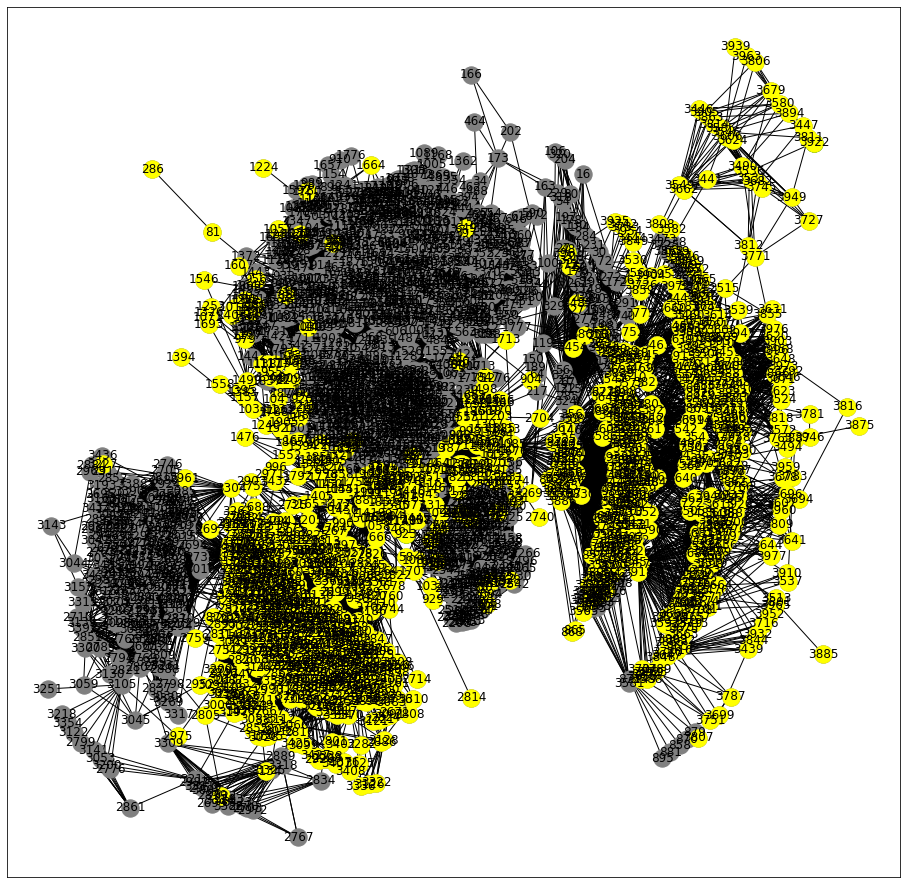

In [458]:
(Model()
    .next_day() 
    .add_contract([3922, 3606, 3961, 3600, 3548, 3652])# , 894]) - 14800 | 502
    .next_days(16)
    .add_contract([961, 923])
    #.add_contract([351, 454]) # 41
    #.add_contract([166]) # 51
    #.add_contract([230, 91, 102, 262])
    #.add_contract([91, 230, 177, 202])
    .next_days(40)
    .draw()
)

7

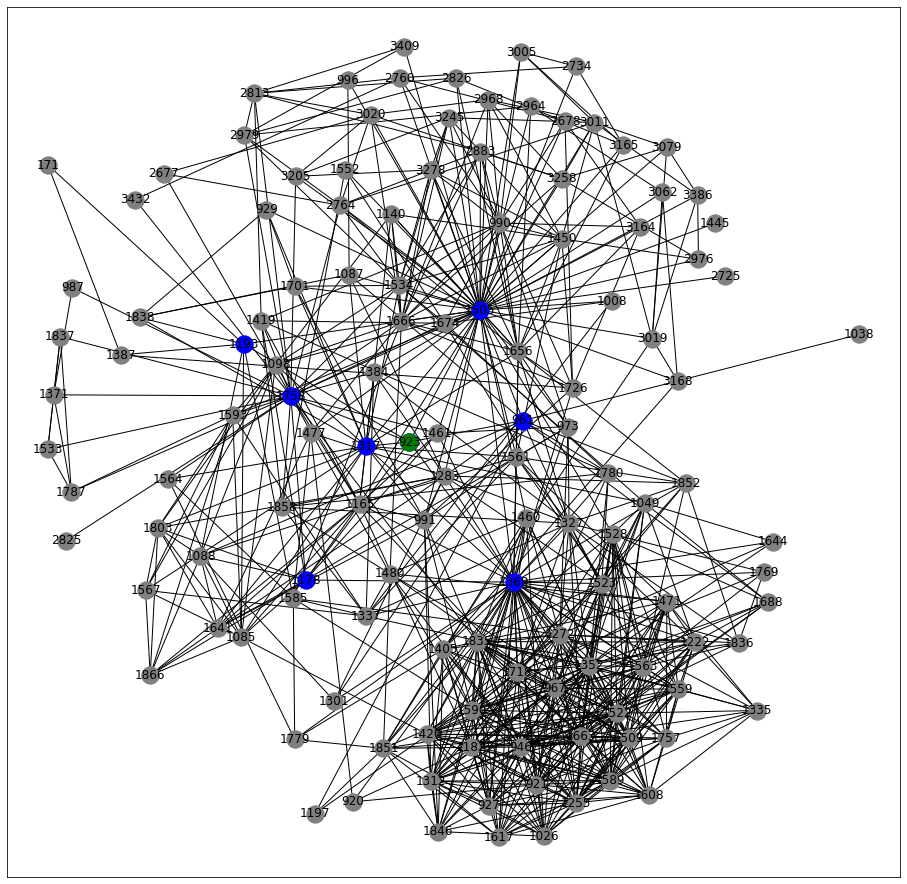

In [450]:
Model() \
    .draw_neighbors(923, force=True)